# cnr-02-roi-dilate

A.L. 20211025 

Unzipped `Marion.zip` from M.L.B 20211006  --> CC1, CC2, CC3; 

CC1 -> 5_t2_tse_HiRes_skra_tra_3mm ,  5_t2_tse_HiRes_skra_tra_3mm_TumorMask_KWL




In [1]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import shutil
import subprocess as subp
import pathlib
import glob
import shutil
from datetime import date
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import scipy
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython


/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
MacOS = True


home = os.path.expanduser('~')            # To make path to local home directory
#datastore = f'{home}/Dropbox/Arvid/MMIV.no/Marion_Berge_PhD_HVL'   # '/media/arvid/sata12tb'
datastore = '../data' 

if MacOS:
    TREE = '/usr/local/bin/tree'          # MacOS (brew install tree)
    MRICONVERT = '/Applications/freesurfer/7.2.0/bin/mri_convert'
    DCMCONVERT = f'{home}/opt/anaconda3/envs/tumor-cnr/bin/dcm2niix'
    
else:
    TREE = '/usr/bin/tree'
    MRICONVERT = '/usr/local/freesurfer/bin/mri_convert'
    DCMCONVERT = f'{home}/anaconda3/envs/tumor-cnr/bin/dcm2niix'

FSLREORIENT2STD = '/usr/local/fsl/bin/fslreorient2std'
FLIRT = '/usr/local/fsl/bin/flirt'
FSLMATHS = '/usr/local/fsl/bin/fslmaths'


dicoms = f'{datastore}/dicom'         
nifti_dcm2niix = f'{datastore}/nifti_dcm2niix' # Converted DICOMS using dcm2niix in Python


#template = 'T1w'


# AD HOC colormap for HD-GLIO  (CE, NE)-segmentation overlay
colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]  # R -> B -> G
n_bins = [2, 3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_cm'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins[0])

## Read converted NIFTI files

In [3]:
subjs = [
    'CC1', 'CC2', 'CC3'
]
subjs

['CC1', 'CC2', 'CC3']

In [4]:
cwd = os.getcwd()
res_dir = f'{cwd}/../data/results'

### Inspect T1w, T2w, FLAIR

In [5]:
sub = 'CC1'
x, y, z = -20, -9, -38    # RAS coordinates
chns = ['t2', 't2_roi']

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


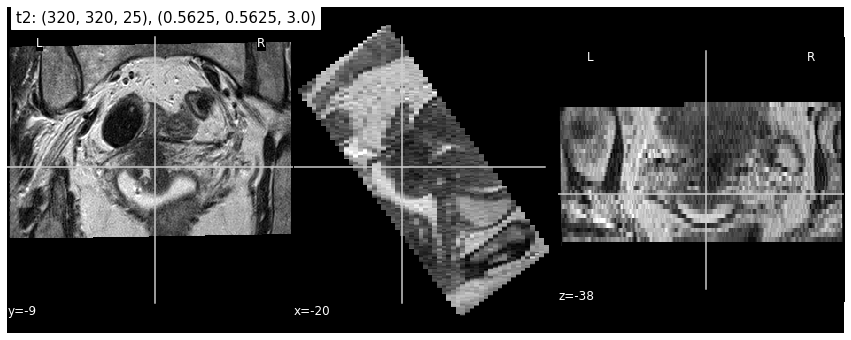

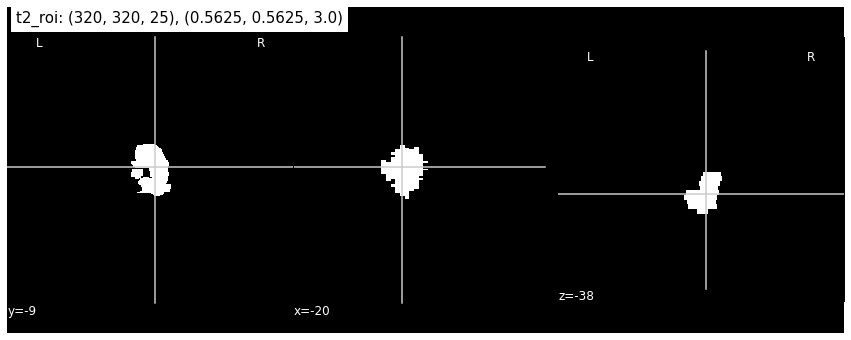

CPU times: user 4.87 s, sys: 112 ms, total: 4.98 s
Wall time: 2.68 s


In [6]:
%%time
for i, chn in enumerate(chns):
    fn_inp = f'{res_dir}/{sub}_{chn}.nii.gz'
    img = nib.load(fn_inp)
    # OrthoSlicer3D(img.get_fdata(), affine= img.affine, title=template).show()
    fig, ax  = plt.subplots(1, 1, figsize=(15,6))
    title = f'{chn}: {img.shape}, {img.header.get_zooms()}'
    plotting.plot_anat(img, axes = ax, title=title, cmap='gray', dim= -0.7, cut_coords = (x, y, z))
    plt.show()

## Display channel image and the ROI

In [7]:
def display_channels_and_roi(T2, roi, BG_IMG):
    channels = [T2]
    img = nib.load(roi)
    data = img.get_fdata()
    values, counts = np.unique(data.astype(int), return_counts=True)
    unique = dict(zip(values,counts))
    coll = list(unique.items())
    unique = dict(coll[1:])
    for i, chn in enumerate(channels):
        if BG_IMG == 'T2' and i==0:
            fig, ax  = plt.subplots(1, 1, figsize=(15,6))
            plotting.plot_roi(roi, axes=ax, title=f'{os.path.split(roi)[1]} ({unique}) on T2', \
                              bg_img=channels[i], alpha=0.8, dim=-0.7, cmap='Blues_r') #cmap='Paired')

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


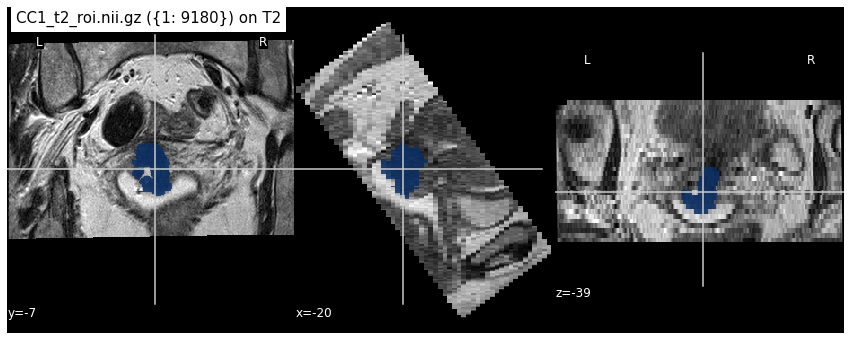

In [8]:
T2 = f'{res_dir}/{sub}_t2.nii.gz'
roi = f'{res_dir}/{sub}_t2_roi.nii.gz'

channels = ['T2']
for BG_IMG in channels:
    display_channels_and_roi(T2, roi, BG_IMG)

## 3D morphological dilation of ROI

- Wikipedia Dilation_(morphology) - https://en.m.wikipedia.org/wiki/Dilation_(morphology)
- Introduction to three-dimensional image processing - https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html
- scipy.ndimage.morphology.binary_dilation - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_dilation.html
- Morphological Transformations (OpenCV) - https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
- Dilating a 3D region in MRI - https://stackoverflow.com/questions/62412913/how-to-speed-up-dilating-a-3d-region-in-a-boolean-numpy-array
- Julia Morphological operations - https://juliaimages.org/dev/examples/image_morphology/image_morphology
- Scikit-Image morphology - https://scikit-image.org/docs/dev/api/skimage.morphology.html


In [10]:
##??scipy.ndimage.binary_dilation
subj = 'CC1'
file_ROI = f'{res_dir}/{subj}_t2_roi.nii.gz'
roi = nib.load(file_ROI)
mask3d = roi.get_fdata()
roi_header = roi.header
roi_affine = roi.affine

https://stackoverflow.com/questions/62412913/how-to-speed-up-dilating-a-3d-region-in-a-boolean-numpy-array

For square- and diamond-shaped neighbourhoods, though, you do have a workaround: dilating once with a diamond of radius 30 is actually the same as dilating 30 times with a diamond of radius 1! You can do this manually in a for-loop, or you can use scipy.ndimage.binary_dilation using the iterations keyword argument. (See this issue for some discussion around this.)

In [11]:
from scipy import ndimage as ndi
import skimage
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)

# make a little 3D diamond:
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)

nx=2  # dilate nx times with it
dilated1 = ndi.binary_dilation(mask3d, diamond, iterations=nx)

print(f'dilated1.dtype: {dilated1.dtype}')

roi_dilated1 = nib.nifti1.Nifti1Image(dilated1.astype(np.bool_),
                                            affine=roi_affine,
                                            header=roi_header)
file_ROI_dilated1 = f'{res_dir}/{subj}_t2_roi_dilated2.nii.gz'
nib.save(roi_dilated1, file_ROI_dilated1)

dilated1.dtype: bool


In [15]:
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.ball
# https://scikit-image.org/docs/dev/auto_examples/numpy_operations/plot_structuring_elements.html#sphx-glr-auto-examples-numpy-operations-plot-structuring-elements-py
# This is the 3D equivalent of a disk. 
# A pixel is within the neighborhood if the Euclidean distance between it and the origin 
# is no greater than radius.

nr = 3
dilated = ndi.binary_dilation(mask3d, structure = ball(radius=nr))


roi_dilated = nib.nifti1.Nifti1Image(dilated.astype(np.bool_),
                                            affine=roi_affine,
                                            header=roi_header)
file_ROI_dilated = f'{res_dir}/{subj}_t2_roi_dilated_ball{nr}.nii.gz'
nib.save(roi_dilated, file_ROI_dilated)

In [20]:
#for scan in ['CC1', 'CC2', 'CC3']:
#    file_ROI = f'{res_dir}/{scan}_t2_roi.{fext}'
#    file_T2w = f'{res_dir}/{scan}_t2.{fext}'

# AD HOC visualization in Freesurfer's `freeview`

In [16]:
subj = 'CC1'

In [17]:
%%bash -s "$subj" "$home"

echo "subject: $1"


FREESURFER_HOME=/Applications/freesurfer/7.2.0; export FREESURFER_HOME   # MacOS
#FREESURFER_HOME=/usr/local/freesurfer; export FREESURFER_HOME
PATH=${FREESURFER_HOME}/bin:${PATH}; export PATH
SUBJECTS_DIR=$2/GitHub/tumor-cnr/data/results; export SUBJECTS_DIR
FSLDIR=/usr/local/fsl; export FSLDIR
PATH=${FSLDIR}/bin:${PATH}; export PATH
. ${FSLDIR}/etc/fslconf/fsl.sh
source ${FREESURFER_HOME}/SetUpFreeSurfer.sh

cd $SUBJECTS_DIR

freeview -v \
$1_t2.nii.gz \
$1_t2_roi.nii.gz:colormap=heat:opacity=0.6 \
-ras -20 -9 -38

subject: CC1
INFO: this is an unsiged short. I'll try to read it, but
      it might not work if there are values over 32k
      it might not work if there are values over 32k
but


In [18]:
from IPython.display import Image
#Image(filename='./assets/hd-glio_003_1.png', width=900)